In [1]:
from pyspark.sql import *
import pandas as pd

In [2]:
spark = SparkSession\
            .builder\
            .appName("Store")\
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/02 17:42:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("./big_data_dataset/*.csv", 
                            header="true",
                            inferSchema="true")
df.createOrReplaceTempView("user_behave")
df.schema
df.show(5)

+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code| brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|2019-11-01 00:00:00|      view|   1003461|2053013555631882655|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 00:00:00|      view|   5000088|2053013566100866035|appliances.sewing...|janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 00:00:01|      view|  17302664|2053013553853497655|                null| creed| 28.31|561587266|755422e7-9040-477...|
|2019-11-01 00:00:01|      view|   3601530|2053013563810775923|appliances.kitche...|    lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 00:00:01|      view|   1004775|2053013555631882655|electronics.smart...|xiaomi

In [5]:
df.dtypes

[('event_time', 'timestamp'),
 ('event_type', 'string'),
 ('product_id', 'int'),
 ('category_id', 'bigint'),
 ('category_code', 'string'),
 ('brand', 'string'),
 ('price', 'double'),
 ('user_id', 'int'),
 ('user_session', 'string')]

In [6]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id)
FROM user_behave
GROUP BY Brand, Price, Product_ID
"""
query = spark.sql(sql)
query.toPandas()

,brand,price,product_id
0,None,20.54,34600011
1,lanvin,56.14,17300705
2,yokohama,97.81,12705975
3,None,99.10,28101002
4,asus,903.73,1307540
...,...,...,...
596916,wera,177.36,22700915
596917,korting,264.56,4502180
596918,None,10.13,26000955
596919,origins,19.08,38700074


In [7]:
query.toPandas().isna().sum()

brand         125305
price              0
product_id         0
dtype: int64

### Getting the brands, products ID and the prices data which do not have missing data

In [8]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id)
FROM user_behave
WHERE brand IS NOT NULL
    AND price > 0
    AND product_id IS NOT NULL
GROUP BY Brand, Price, Product_ID
"""
to_predict = spark.sql(sql).toPandas()
to_predict

,brand,price,product_id
0,lanvin,56.14,17300705
1,yokohama,97.81,12705975
2,asus,903.73,1307540
3,nokia,406.67,1003441
4,samsung,1133.36,1005073
...,...,...,...
471611,lirene,2.55,17601772
471612,wera,177.36,22700915
471613,korting,264.56,4502180
471614,origins,19.08,38700074


### The data where the price is missing

In [9]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id)
FROM user_behave
WHERE brand IS NOT NULL
    AND price IS NULL
    AND product_id IS NOT NULL
GROUP BY Brand, Price, Product_ID
"""
predict = spark.sql(sql).toPandas()
predict

,brand,price,product_id


### Getting the data when the brand is missing

In [10]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id)
FROM user_behave
WHERE brand IS NULL
    AND price IS NOT NULL
    AND product_id IS NOT NULL
GROUP BY Brand, Price, Product_ID
"""
p = spark.sql(sql).toPandas()
p

,brand,price,product_id
0,None,20.54,34600011
1,None,99.10,28101002
2,None,58.69,28000018
3,None,835.29,15100230
4,None,21.96,32401181
...,...,...,...
125300,None,4.14,24700094
125301,None,49.80,28101764
125302,None,0.00,100027667
125303,None,50.71,28714948


In [4]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id), category_code, event_type
FROM user_behave
GROUP BY Brand, Price, Product_ID, category_code, event_type
"""
q = spark.sql(sql)
q.toPandas()

,brand,price,product_id,category_code,event_type
0,honor,47.62,5100851,None,view
1,luminarc,57.66,31501171,None,view
2,samsung,463.31,4600667,appliances.kitchen.dishwasher,view
3,samsung,720.22,1003712,electronics.smartphone,view
4,gezatone,39.90,29100027,appliances.personal.massager,view
...,...,...,...,...,...
884736,crucial,203.84,6600562,computers.components.memory,view
884737,yokohama,139.90,12719203,None,view
884738,kisswill,2.48,18001220,None,view
884739,garmin,488.39,5900150,None,view


### Data where the Event is missing

In [18]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id), category_code, event_type
FROM user_behave
WHERE brand IS NOT NULL
    AND category_code IS NOT NULL
    AND event_type IS NULL
GROUP BY Brand, Price, Product_ID, category_code, event_type
"""
q1 = spark.sql(sql)
q1.toPandas()

,brand,price,product_id,category_code,event_type


### Getting the data when the category is missed

In [19]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id), category_code, event_type
FROM user_behave
WHERE brand IS NOT NULL
    AND category_code IS NULL
    AND event_type IS NOT NULL
GROUP BY Brand, Price, Product_ID, category_code, event_type
"""
q2 = spark.sql(sql)
q2.toPandas()

,brand,price,product_id,category_code,event_type
0,honor,47.62,5100851,None,view
1,luminarc,57.66,31501171,None,view
2,artmusical,123.56,41200013,None,view
3,chicco,149.27,8000002,None,view
4,cordiant,39.38,12703014,None,view
...,...,...,...,...,...
296407,montblanc,59.48,100019537,None,view
296408,dvizenie,28.83,100012446,None,cart
296409,yokohama,139.90,12719203,None,view
296410,kisswill,2.48,18001220,None,view


# The data when the data is not missing

In [20]:
sql = """
SELECT brand, DOUBLE(`price`), INT(product_id), category_code, event_type
FROM user_behave
WHERE brand IS NOT NULL
    AND category_code IS NOT NULL
    AND event_type IS NOT NULL
GROUP BY Brand, Price, Product_ID, category_code, event_type
"""
query1 = spark.sql(sql)
query1.toPandas()

,brand,price,product_id,category_code,event_type
0,samsung,463.31,4600667,appliances.kitchen.dishwasher,view
1,samsung,720.22,1003712,electronics.smartphone,view
2,gezatone,39.90,29100027,appliances.personal.massager,view
3,respect,71.82,28716984,apparel.shoes.keds,view
4,caprice,42.47,28713988,apparel.shoes.ballet_shoes,view
...,...,...,...,...,...
414972,jetair,169.52,2401723,appliances.kitchen.hood,view
414973,nexpero,79.02,28721177,apparel.shoes,purchase
414974,wintek,28.18,9700406,computers.components.power_supply,view
414975,crucial,203.84,6600562,computers.components.memory,view


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### Visualizing the missing category

<AxesSubplot: >

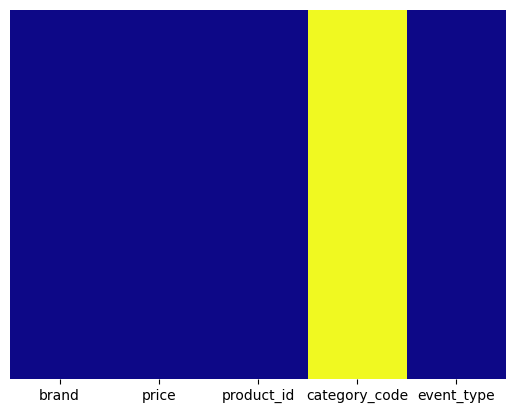

In [23]:
sns.heatmap(q2.toPandas().isnull(),yticklabels=False,cbar=False,cmap='plasma')  

TypeError: set_major_formatter() missing 1 required positional argument: 'formatter'

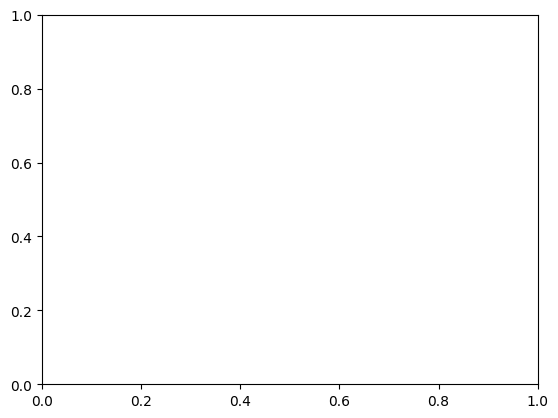

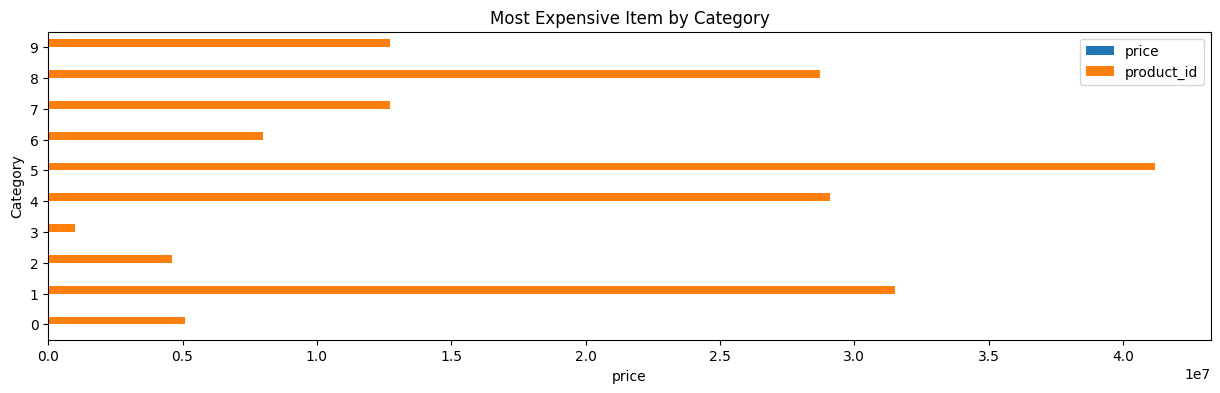

In [9]:
plt.subplots()
ax1=q.toPandas().head(10).plot(figsize = (15,4),
                kind = 'barh')
ax1.set_xlabel('price')
ax1.set_ylabel('Category')
ax1.set_title('Most Expensive Item by Category')
ax1.xaxis.set_major_formatter()



/tmp/ipykernel_618/1199117670.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = q.toPandas().corr()


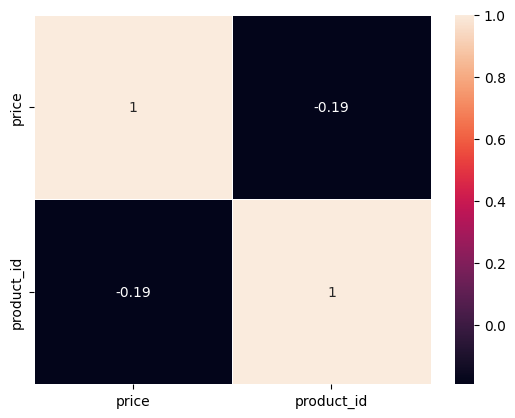

In [7]:
corr = q.toPandas().corr()
sns.heatmap(corr, annot=True, linewidths=0.5)
plt.show()